## Overview: Analysis using gamm4 package (package used on DEAP website)
### Preparation
1. Install packages and load libraries
1. Set working directory and import data
1. Replace 999/777 in income and education 
1. Specify data type (numeric/factor/ordinal)
1. Exploration: mri_info_deviceserialnumber and site_id_l
1. Copy smri variables and change colnames before winsorization 
1. Standardize smri_vol variables
1. Winsorize smri vol variables

### Work in progress
1. Loop gamm4 over dependent variables
1. How to deal with weights argument (solve error)

### Preparation

#### 1. Install packages and load libraries

In [124]:
if (!('gamm4'     %in% installed.packages()[,"Package"])) install.packages('gamm4')
if (!('rjson'     %in% installed.packages()[,"Package"])) install.packages('rjson')
if (!('stargazer' %in% installed.packages()[,"Package"])) install.packages('stargazer')
if (!('knitr'     %in% installed.packages()[,"Package"])) install.packages('knitr')
if (!('MuMIn'     %in% installed.packages()[,"Package"])) install.packages('MuMIn')
if (!('R.matlab'  %in% installed.packages()[,"Package"])) install.packages('R.matlab')
if (!('tableone'  %in% installed.packages()[,"Package"])) install.packages('tableone')
if (!('survey'    %in% installed.packages()[,"Package"])) install.packages('survey')
if (!('naniar'   %in% installed.packages()[,"Package"])) install.packages('naniar')
if (!('pander'   %in% installed.packages()[,"Package"])) install.packages('pander')
if (!('tidyverse'   %in% installed.packages()[,"Package"])) install.packages('tidyverse')
if (!('broom'   %in% installed.packages()[,"Package"])) install.packages('broom')
if (!('robustHD' %in% installed.packages()[,"Package"])) install.packages('robustHD')

if(!"gamm4" %in% .packages())     library(gamm4)
if(!"rjson" %in% .packages())     library(rjson)
if(!"stargazer" %in% .packages()) library(stargazer)
if(!"knitr" %in% .packages())     library(knitr)
if(!"MuMIn" %in% .packages())     library(MuMIn)
if(!"R.matlab" %in% .packages())  library(R.matlab)
if(!"tableone" %in% .packages())  library(tableone)
if(!"survey" %in% .packages())    library(survey)
if(!"naniar" %in% .packages())   library(naniar)
if(!"pander" %in% .packages())   library(pander)
if(!"tidyverse" %in% .packages())   library(tidyverse)
if(!"broom" %in% .packages())   library(broom)
if(!"robustHD" %in% .packages())  library(robustHD)

#### 2. Set working directory and import data

In [125]:
#set working directory to import PsychRisk3.tsv file that was created with the psychrisk_exploration.ipynb notebook
setwd("/shared/project-psychopathology-risk/outputs/exploration/")
df <- read.table(file = 'PsychRisk_data.tsv', sep = '\t', header = TRUE)

#### 3. Replace 999/777 in income and education, create puberty status variable and drop variables. 

In [126]:
# replace value 999 and 777 (don't know and refused to answer) to NA
df <- df %>%
  replace_with_na(replace = list(demo_comb_income_v2 = c(999, 777), 
                                 demo_prnt_ed_v2 = c(777)))

df$puberty <- ifelse(!is.na(df$pds_p_ss_female_category),df$pds_p_ss_female_category,df$pds_p_ss_male_category)
table(df$puberty, exclude=NULL)  #364 NAs

# drop variables that are not needed. Do not change because names1 will not be correct anymore. \n",
drop <- c("pds_p_ss_female_category", "pds_p_ss_male_category", "eventname", "mri_info_deviceserialnumber", "iqc_t1_ok_ser", "fsqc_qc", "mrif_score", "demo_prim")
df2 = df[,!(names(df) %in% drop)]


   1    2    3    4    5 <NA> 
5291 2408 2366  152    8  364 

#### 4. Specify data type (numeric/factor/ordinal)

In [127]:
names1 <- c(1,4,5, 7,8, 25:47, 187:193)  #column numbers categorical variables
df2[names1]<- lapply(df2[names1],factor)
df2$interview_date <- as.Date(df2$interview_date, "%m/%d/%Y")
df2$interview_age <- as.numeric(df2$interview_age)
df2$demo_comb_income_v2_order <- factor(df2$demo_comb_income_v2, order = TRUE)
df2$demo_prnt_ed_v2_order <- factor(df2$demo_prnt_ed_v2, order = TRUE)
df2$puberty <- factor(df2$puberty, order = TRUE)

str(df2, list.len=ncol(df2)) #sanity check

'data.frame':	10589 obs. of  196 variables:
 $ subjectkey                   : Factor w/ 10589 levels "NDAR_INV003RTV85",..: 9 22 25 35 39 43 48 55 68 86 ...
 $ interview_date               : Date, format: "2017-08-19" "2017-08-09" ...
 $ interview_age                : num  121 129 122 122 126 128 128 120 122 127 ...
 $ sex                          : Factor w/ 2 levels "F","M": 2 2 1 2 1 2 1 1 2 1 ...
 $ rel_family_id                : Factor w/ 8834 levels "1","3","4","5",..: 6129 661 8524 6485 6130 7273 2425 6486 8525 6490 ...
 $ acs_raked_propensity_score   : num  616 426 322 428 959 ...
 $ race_ethnicity               : Factor w/ 5 levels "1","2","3","4",..: 5 1 1 1 1 1 1 3 1 1 ...
 $ site_id_l                    : Factor w/ 22 levels "site01","site02",..: 11 16 2 6 11 9 14 6 2 6 ...
 $ smri_vol_scs_aal             : num  525 535 522 484 535 ...
 $ smri_vol_scs_aar             : num  580 646 579 622 557 ...
 $ smri_vol_scs_amygdalalh      : num  1668 1430 1514 1404 1905 ...
 $ smri_v

#### 6. Create df with smri variables, change colnames and standardize smri variables

In [128]:
#create new df with smri variables and add win prefix to column names 
smri <- df2[grepl("^smri", colnames(df2))] 
colnames(smri) <-paste("win",colnames(smri),sep="_") 

#standardization function
scale.many <- function(dat, column.nos) {
  nms <- names(dat)
  for(col in column.nos) {
    name <- paste(nms[col],".z", sep = "")
    dat[name] <- scale(dat[,col])
  }
  cat(paste("Scaled ", length(column.nos), " variable(s)\n"))
  dat
}

Scaled  155  variable(s)


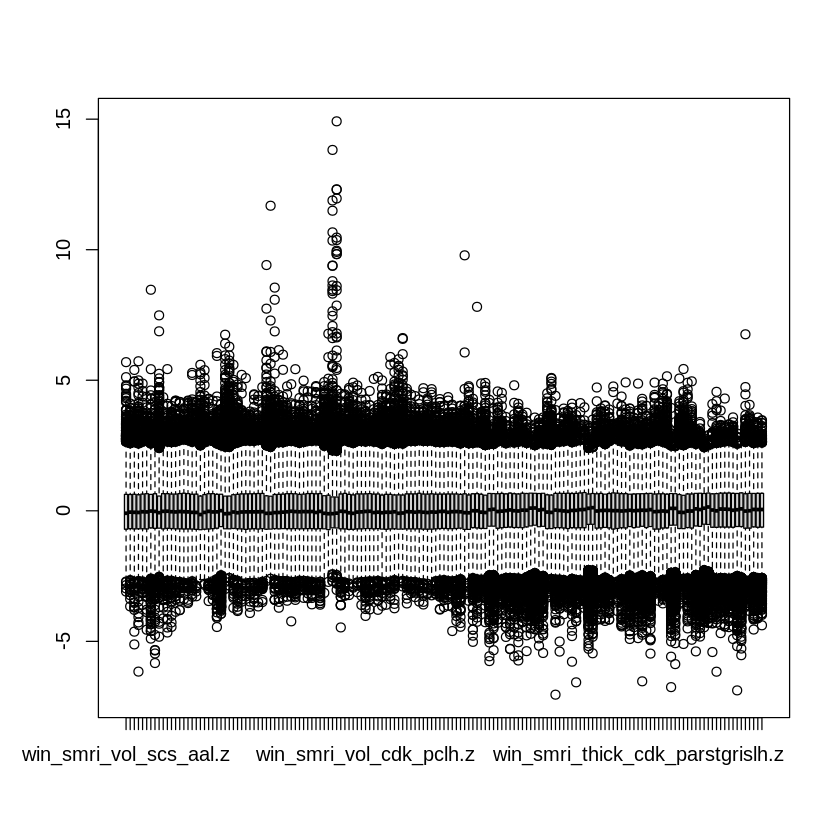

In [129]:
#standardize smri variables
smri_w <- scale.many(smri, c(1:155))

#keep standarized only
smri_w <- smri_w[ -c(1:155) ] 
boxplot(smri_w)

#### 7. Winsorize smri vol variables if 3sd above or below mean

Scaled  2  variable(s)


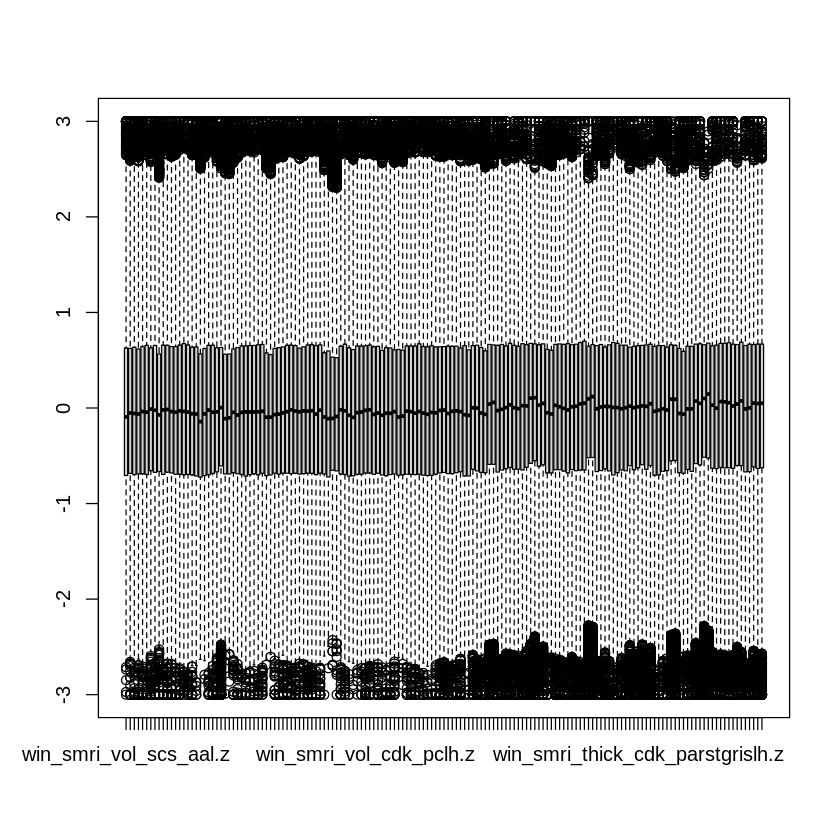

In [130]:
df3 <- smri_w
    
# Winsorization function
fun <- function(x){
    x[ x < -3 ] <- -3
    x[ x > 3 ] <- 3
    x
}

# Apply winsorization 
df3 <- fun(df3)
boxplot(df3) #check whether all values are within -3 and +3

# combine dataframes and standardize age
df4 <- cbind(df2, df3)
df4 <- scale.many(df4, c(3, 6)) #standardized age and acs_propensity

### GAMM4 

1. GAMM4 with one outcome variable
1. GAMM4 loop over all outcome variables
1. Extract estimates, t-values and p-values
1. Create heatmaps

### Work in progress

1. It is possible to apply smoothing, but I don't understand when or why to do this.
1. How to calculate effect size?


#### 1. GAMM4 with one outcome variable

In [131]:
# This works for 1 subject without weights argument. If including weights there is an error: variable lengths differ (found for '(weights)').
# Next step is to loop it over all dependentVars 
# Examine why weights reveals this error. 

# Define dependent var
dependentVar = colnames(df4)[grepl("^win_smri_vol_scs.*.z$", colnames(df4)) & !grepl("smri_vol_scs_intracranialv", colnames(df4))]

# Run model - manually adjust dependentVar number [[*]]
model <- gamm4(as.formula(paste(dependentVar[[5]], "~ win_smri_vol_scs_intracranialv.z+
                                                interview_age.z+ sex+ 
                                                race_ethnicity+ 
                                                puberty+
                                                demo_prnt_ed_v2+
                                                demo_comb_income_v2+
                                                famhx_ss_momdad_dprs_p+ famhx_ss_momdad_addiction+ famhx_ss_momdad_ma_p+ 
                                                famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_ma_p+ famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_addiction:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_ma_p:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p:famhx_ss_momdad_nrv_p")), 
                               random = ~(1|site_id_l/rel_family_id), data = df4)

summary(model$gam)


Family: gaussian 
Link function: identity 

Formula:
win_smri_vol_scs_caudatelh.z ~ win_smri_vol_scs_intracranialv.z + 
    interview_age.z + sex + race_ethnicity + puberty + demo_prnt_ed_v2 + 
    demo_comb_income_v2 + famhx_ss_momdad_dprs_p + famhx_ss_momdad_addiction + 
    famhx_ss_momdad_ma_p + famhx_ss_momdad_nrv_p + famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction + 
    famhx_ss_momdad_dprs_p:famhx_ss_momdad_ma_p + famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p + 
    famhx_ss_momdad_dprs_p:famhx_ss_momdad_nrv_p + famhx_ss_momdad_addiction:famhx_ss_momdad_nrv_p + 
    famhx_ss_momdad_ma_p:famhx_ss_momdad_nrv_p + famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p + 
    famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction:famhx_ss_momdad_nrv_p + 
    famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p:famhx_ss_momdad_nrv_p

Parametric coefficients:
                                                                           Estimate
(Intercept)                          

Interpretation: https://cran.r-project.org/web/packages/gamm4/gamm4.pdf
Returns a list with two items for each dependent variable:
gam an object of class gam. At present this contains enough information to use
predict, plot, summary and print methods and vis.gam, from package mgcv
but not to use e.g. the anova method function to compare models.
mer the fitted model object returned by lmer or glmer. Extra random and fixed
effect terms will appear relating to the estimation of the smooth terms. Note that
unlike lme objects returned by gamm, everything in this object always relates to
the fitted model itself, and never to a PQL working approximation: hence the
usual methods of model comparison are entirely legitimate.

#### 2. GAMM4 loop over all outcome variables

In [132]:
# Define dependent var
dependentVar = colnames(df4)[grepl("^win_smri_vol_scs.*.z$", colnames(df4)) & !grepl("smri_vol_scs_intracranialv", colnames(df4))]
no.dependentVar = length(dependentVar)
m <- as.list(1:no.dependentVar)
ptab <- data.frame(matrix(NA, nrow = 54, ncol = 5))
names(m) <- dependentVar

#for loop
    for (i in 1:no.dependentVar) {
        print(paste("Running gamm4 for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
    
        # Run model - manually adjust dependentVar number [[*]]
        m[[i]] <- gamm4(as.formula(paste(dependentVar[[i]], "~ win_smri_vol_scs_intracranialv.z+
                                                interview_age.z+ sex+ 
                                                race_ethnicity+ 
                                                puberty+
                                                demo_prnt_ed_v2_order+
                                                demo_comb_income_v2_order+
                                                famhx_ss_momdad_dprs_p+ famhx_ss_momdad_addiction+ famhx_ss_momdad_ma_p+ 
                                                famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_ma_p+ famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_addiction:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_ma_p:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p+
                                                famhx_ss_momdad_dprs_p:famhx_ss_momdad_addiction:famhx_ss_momdad_nrv_p+
                                                famhx_ss_momdad_addiction:famhx_ss_momdad_ma_p:famhx_ss_momdad_nrv_p")), 
                               random = ~(1|site_id_l/rel_family_id), data = df4)

        #fixed effects in table format       
        ptab[[i]]= as.data.frame(summary(m[[i]]$gam)$p.table)
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] = "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] = "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] = "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] = "***"
        ptab[[i]]$`Pr(>|t|)` = round(ptab[[i]]$`Pr(>|t|)`,7)
            }



[1] "Running gamm4 for dependent variable: win_smri_vol_scs_aal.z which is 1 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_aar.z which is 2 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_amygdalalh.z which is 3 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_amygdalarh.z which is 4 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_caudatelh.z which is 5 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_caudaterh.z which is 6 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_hpuslh.z which is 7 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_hpusrh.z which is 8 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_pallidumlh.z which is 9 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_pallidumrh.z which is 10 out of 15"
[1] "Running gamm4 for dependent variable: win_smri_vol_scs_putamenlh.z w

In [ ]:
#View summary results
summary(m[[5]]$gam) # insert number based on location dependentVar or alternatively insert name: eg summary(m[["win_smri_vol_scs_aal.z"]]$gam) 

#View results fixed effects in table format
ptab[[5]] 

# heatmaps are created later, so no need to examine every ptab dataframe

#### 3. Extract estimates, t-values and p-values (preparation for heatmaps)


In [133]:
# Create empty dataframes
rows <- rownames(as.data.frame(summary(m[[1]]$gam)[1]))
est.val <- data.frame(matrix(NA, nrow = 54, ncol = 15))
colnames(est.val) <- dependentVar
rownames(est.val) <- rows
t.val <- data.frame(matrix(NA, nrow = 54, ncol = 15))
colnames(t.val) <- dependentVar
rownames(t.val) <- rows
p.val <- data.frame(matrix(NA, nrow = 54, ncol = 15))
colnames(p.val) <- dependentVar
rownames(p.val) <- rows

# Extract estimates, t-values and p-values of all models
for (i in 1:no.dependentVar) {
    est.val[i] <- as.data.frame(summary(m[[i]]$gam)[1]) #dataframe with estimates
    t.val[i] <- as.data.frame(summary(m[[i]]$gam)[3])   #dataframe with t-values
    p.val[i] <- as.data.frame(summary(m[[i]]$gam)[4])   #dataframe with p-values
                          }

In [134]:
# create dataframe with only pathology estimates, t-values and p-values for pathology 
est.val.path <- est.val[42:54,]   #dataframe with estimates of parent pathology
t.val.path <- t.val[42:54,]       #dataframe with t-values of parent pathology
p.val.path <- p.val[42:54,]       #dataframe with p-values of parent pathology

#### 4. Create heatmaps

In [135]:
# create heatmap of estimates, t-values or p-values
dt2 <- p.val.path %>%                    #change p to t or est for t and estimates heatmaps
  rownames_to_column() %>%
  gather(colname, value, -rowname)

dt2$rowname[dt2$rowname == "famhx_ss_momdad_dprs_p1"] <- "D"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_addiction1"] <- "A"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_ma_p1"] <- "M"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_nrv_p1"] <- "N"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_dprs_p1:famhx_ss_momdad_addiction1"] <- "DA"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_dprs_p1:famhx_ss_momdad_ma_p1"] <- "DM"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_addiction1:famhx_ss_momdad_ma_p1"] <- "AM"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_dprs_p1:famhx_ss_momdad_nrv_p1"] <- "DN"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_addiction1:famhx_ss_momdad_nrv_p1"] <- "AN"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_ma_p1:famhx_ss_momdad_nrv_p1"] <- "MN"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_dprs_p1:famhx_ss_momdad_addiction1:famhx_ss_momdad_ma_p1"] <- "DAM"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_dprs_p1:famhx_ss_momdad_addiction1:famhx_ss_momdad_nrv_p1"] <- "DAN"
dt2$rowname[dt2$rowname == "famhx_ss_momdad_addiction1:famhx_ss_momdad_ma_p1:famhx_ss_momdad_nrv_p1"] <- "AMN"

dt2$colname[dt2$colname == "win_smri_vol_scs_aal.z"] <- "aal"
dt2$colname[dt2$colname == "win_smri_vol_scs_aar.z"] <- "aar"
dt2$colname[dt2$colname == "win_smri_vol_scs_amygdalalh.z"] <- "amygdalalh"
dt2$colname[dt2$colname == "win_smri_vol_scs_amygdalarh.z"] <- "amygdalarh"
dt2$colname[dt2$colname == "win_smri_vol_scs_caudatelh.z"] <- "caudatelh"
dt2$colname[dt2$colname == "win_smri_vol_scs_caudaterh.z"] <- "caudaterh"
dt2$colname[dt2$colname == "win_smri_vol_scs_hpuslh.z"] <- "hpuslh"
dt2$colname[dt2$colname == "win_smri_vol_scs_hpusrh.z"] <- "hpusrh"
dt2$colname[dt2$colname == "win_smri_vol_scs_pallidumlh.z"] <- "pallidumlh"
dt2$colname[dt2$colname == "win_smri_vol_scs_pallidumrh.z"] <- "pallidumrh"
dt2$colname[dt2$colname == "win_smri_vol_scs_putamenlh.z"] <- "putamenlh"
dt2$colname[dt2$colname == "win_smri_vol_scs_putamenrh.z"] <- "putamenrh"
dt2$colname[dt2$colname == "win_smri_vol_scs_tplh.z"] <- "tplh"
dt2$colname[dt2$colname == "win_smri_vol_scs_tprh.z"] <- "tprh"
dt2$colname[dt2$colname == "win_smri_vol_scs_subcorticalgv.z"] <- "subcorticalgv"
# sort alphabetically
dt2$colname = factor(dt2$colname, levels=sort(unique(dt2$colname), decreasing=TRUE))

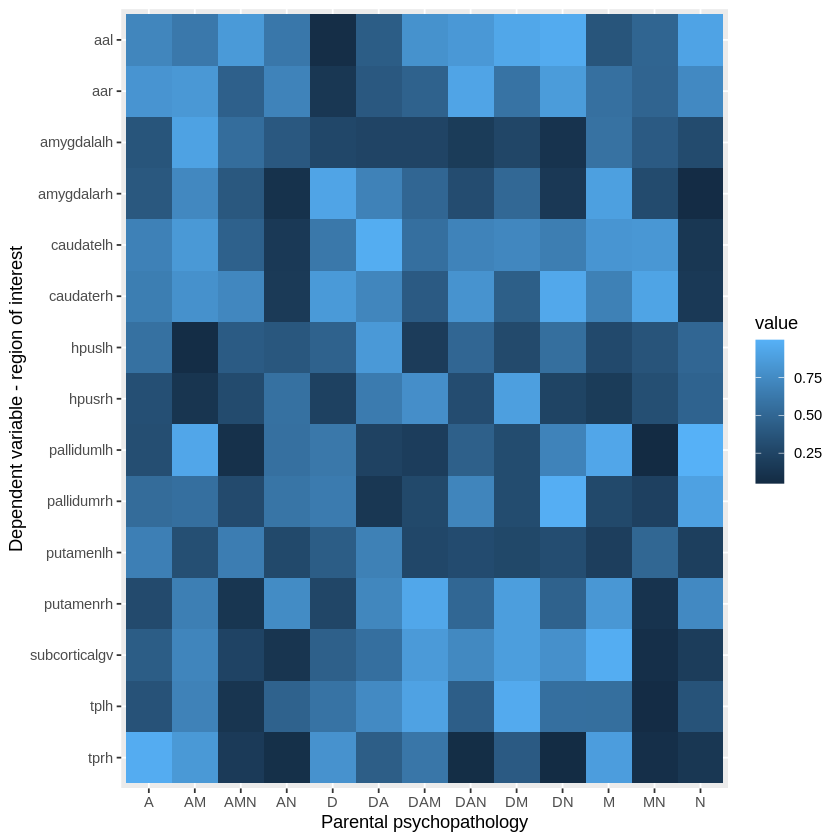

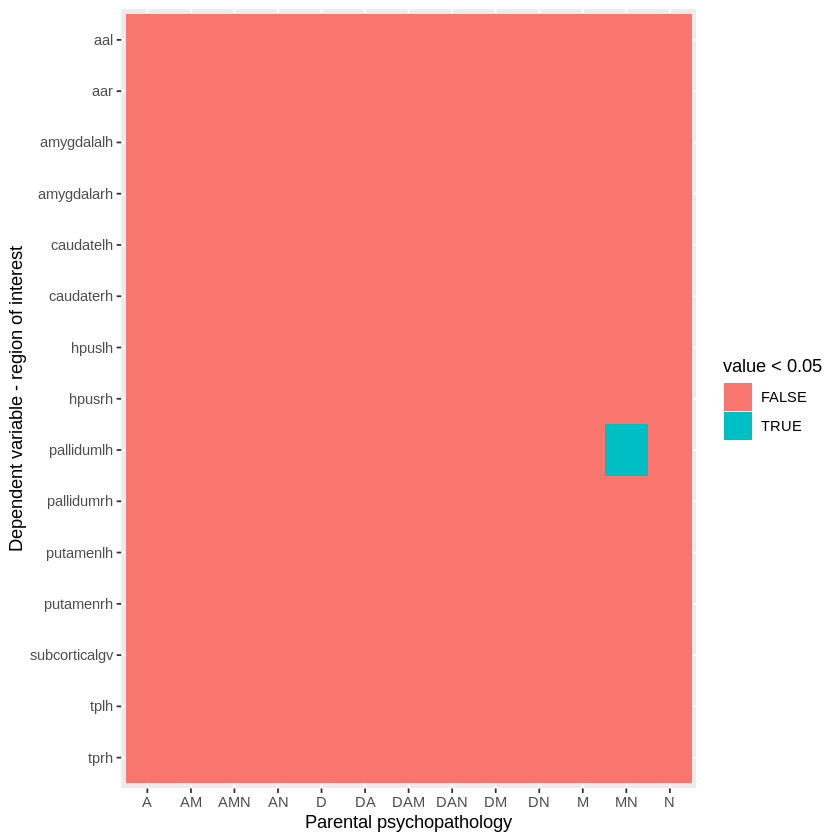

In [136]:
#Heatmap
p1 <- ggplot(dt2, aes(x = rowname, y = colname, fill = value)) +
  geom_tile() +
  labs(y="Dependent variable - region of interest", x = "Parental psychopathology")
plot(p1)

# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2 <- ggplot(dt2, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile() +
  labs(y="Dependent variable - region of interest", x = "Parental psychopathology")
plot(p2)

In [96]:
#Explore left pallidum 
ptab[[9]]

,Estimate,Std. Error,t value,Pr(>|t|),sig
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),2.891174e-02,0.109604089,2.637834e-01,0.7919531,NA
win_smri_vol_scs_intracranialv.z,4.618575e-01,0.011838266,3.901395e+01,0.0000000,***
interview_age.z,-8.700753e-02,0.009364843,-9.290870e+00,0.0000000,***
sexM,1.631961e-01,0.023619965,6.909245e+00,0.0000000,***
race_ethnicity2,2.337429e-02,0.036010540,6.490958e-01,0.5162936,NA
race_ethnicity3,7.441472e-02,0.030128170,2.469938e+00,0.0135326,*
race_ethnicity4,1.612851e-01,0.072980617,2.209971e+00,0.0271330,*
race_ethnicity5,3.986156e-02,0.032903178,1.211481e+00,0.2257441,NA
puberty.L,-2.821753e-01,0.240110377,-1.175190e+00,0.2399508,NA


### NOT SURE HOW TO CALCULATE EFFECT SIZE
In t_to_d documentation input arguments are specified as t and df_error where df_error is defined as: Degrees of freedom of numerator or of the error estimate (i.e., the residuals).
It is not clear how to extract df_error model parameters. 
1. edf = all values are close to 1 -> unlikely
1. residuals(m[[i]]$gam)

1. m[[i]]$gam$residuals

In [ ]:
if (!('effectsize' %in% installed.packages()[,"Package"])) install.packages('effectsize')
if(!"effectsize" %in% .packages())     library(effectsize)

In [ ]:
? t_to_d

In [ ]:
# Extract estimates, t-values and p-values of all models
rows <- rownames(as.data.frame(summary(m[[1]]$gam)[1]))
edf <- data.frame(matrix(NA, nrow = 52, ncol = 15))
colnames(edf) <- dependentVar
rownames(edf) <- rows

for (i in 1:no.dependentVar) {
    edf[i]<- as.data.frame(m[[i]]$gam[23])
                          }

In [ ]:
for (i in 1:no.dependentVar) {
rs[[i]] <- (t_to_d(ptab[[i]]$t[2:50],edf[[i]][2:50]))
    }

In [ ]:
r1<-as.vector(residuals(m[[1]]$gam))
r2<-as.vector(m[[1]]$gam$residuals)


In [ ]:
rs[[5]]